In [39]:
import cv2

from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import cKDTree
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
import copy


from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert



file = "E:/heatmap/pictures/TRAP2-Ai14 Heat GiA descending L5 10X2.png"

C:\Users\liuy42\AppData\Local\Temp\ipykernel_16616\1423633145.py:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [8]:
drawing=False # true if mouse is pressed
mode=True # if True, draw rectangle. Press 'm' to toggle to curve

# mouse callback function
def begueradj_draw(event,former_x,former_y,flags,param):
    global current_former_x,current_former_y,drawing, mode

    if event==cv2.EVENT_LBUTTONDOWN:
        drawing=True
        current_former_x,current_former_y=former_x,former_y

    elif event==cv2.EVENT_MOUSEMOVE:
        if drawing==True:
            if mode==True:
                cv2.line(im,(current_former_x,current_former_y),(former_x,former_y),(0,0,0),2)
                current_former_x = former_x
                current_former_y = former_y
                #print former_x,former_y
    elif event==cv2.EVENT_LBUTTONUP:
        drawing=False
        if mode==True:
            cv2.line(im,(current_former_x,current_former_y),(former_x,former_y),(0,0,0),2)
            current_former_x = former_x
            current_former_y = former_y
    return former_x,former_y    



im = cv2.imread(file)
cache = copy.deepcopy(im)
cv2.namedWindow("TRACE DORSAL HORN", cv2.WINDOW_NORMAL)
cv2.setMouseCallback('TRACE DORSAL HORN',begueradj_draw)
while(1):
    cv2.imshow('TRACE DORSAL HORN',im)
    k=cv2.waitKey(1)&0xFF
    if k==27:
        im = copy.deepcopy(cache)
        cv2.imshow('TRACE DORSAL HORN',im)
    elif k==13:
        towrite = file[0:-4] + " border" + file[-4:]
        cv2.imwrite(towrite, im)
        break
    elif k==8:
        break
cv2.destroyAllWindows()

In [9]:
#src = cv2.imread(towrite, cv2.IMREAD_GRAYSCALE)
thresh = 0
maxValue = 255
th, dst = cv2.threshold(im, thresh, maxValue, cv2.THRESH_BINARY)

def thresh_slide(x):
    global im, dst
    thresh = x
    th, dst = cv2.threshold(im, x, maxValue, cv2.THRESH_BINARY)
    img = np.concatenate((dst, im), axis=1)
    cv2.imshow('THRESH_WINDOW', img)
    

cv2.namedWindow('THRESH_WINDOW', cv2.WINDOW_NORMAL)
cv2.createTrackbar('TRACKBAR', 'THRESH_WINDOW', 0, 200, thresh_slide)

#cv2.imshow('THRESH', dst)
cv2.waitKey(0)

towrite = file[0:-4] + " thresholded" + file[-4:]
cv2.imwrite(towrite, dst)
cv2.destroyAllWindows()


In [10]:
# img = cv2.imread(towrite)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
thresh_inv = 255-dst

contours = cv2.findContours(thresh_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)

mask = np.zeros(dst.shape, dtype=np.uint8)
cv2.drawContours(mask, [big_contour], 0, (255,255,255), cv2.FILLED)

mask_inv = 255 - mask

# create new (white) background
bckgnd = np.full_like(dst, 255)

image_masked = cv2.bitwise_and(dst, dst, mask=mask)

# apply inverse mask to background
bckgnd_masked = cv2.bitwise_and(bckgnd, bckgnd, mask=mask_inv)

result = cv2.add(image_masked, bckgnd_masked)

cv2.namedWindow('contours', cv2.WINDOW_NORMAL)
cv2.imshow("contours", result)

towrite = file[0:-4] + " masked" + file[-4:]
cv2.imwrite(towrite, result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [11]:
result = cv2.imread(towrite)
result_gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
contours, hier = cv2.findContours(result_gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

#erase drawn contour
cv2.drawContours(result, [contours[-3]],0,(255,255,255),10)

towrite = file[0:-4] + " masked++" + file[-4:]
cv2.imwrite(towrite, result)

for cnt in contours[:-3]:
    #if 200<cv2.contourArea(cnt)<5000:
    cv2.drawContours(result,[cnt],0,(0,255,0),1)

cv2.namedWindow('result', cv2.WINDOW_NORMAL)
cv2.imshow("result", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [40]:
def skeletonize(img):
    """ OpenCV function to return a skeletonized version of img, a Mat object"""

    #  hat tip to http://felix.abecassis.me/2011/09/opencv-morphological-skeleton/

    img = img.copy() # don't clobber original
    skel = img.copy()

    skel[:,:] = 0
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

    while True:
        eroded = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
        temp = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel)
        temp  = cv2.subtract(img, temp)
        skel = cv2.bitwise_or(skel, temp)
        img[:,:] = eroded[:,:]
        if cv2.countNonZero(img) == 0:
            break

    return skel

result = cv2.imread(towrite)
result_gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
skel = skeletonize(result_gray)

cv2.imshow("skeleton", skel)
cv2.waitKey(0)

towrite = file[0:-4] + " skeleton" + file[-4:]
cv2.imwrite(towrite, skel)
cv2.destroyAllWindows()

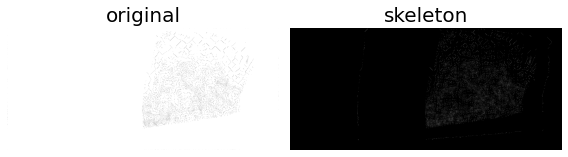

In [42]:
image = invert(result_gray)

# perform skeletonization
skeleton = skeletonize(image)

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.rcParams['figure.dpi'] = 800
plt.show()

In [13]:

# def myplot(x, y, s, bins=1000):
#     heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
#     heatmap = gaussian_filter(heatmap, sigma=s)

#     extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
#     return heatmap.T, extent


# fig, axs = plt.subplots(2, 2)

# # Generate some test data
# # x = np.where(skel == 255)[1]
# # y = np.where(skel == 255)[0]
# x = np.where(result_gray == 0)[1]
# y = np.where(result_gray == 0)[0]

# sigmas = [0, 16, 32, 64]

# for ax, s in zip(axs.flatten(), sigmas):
#     if s == 0:
#         ax.plot(x, y, 'k.', markersize=5)
#         ax.set_title("Scatter plot")
#     else:
#         img, extent = myplot(x, y, s)
#         ax.imshow(img, extent=extent, origin='upper', cmap=cm.jet)
#         ax.set_title("Smoothing with  $\sigma$ = %d" % s)

# plt.show()

In [14]:

# def myplot(x, y, s, bins=1000):
#     heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
#     heatmap = gaussian_filter(heatmap, sigma=s)

#     extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
#     return heatmap.T, extent


# fig, axs = plt.subplots(2, 2)

# # Generate some test data
# x = np.where(skel == 255)[1]
# y = np.where(skel == 255)[0]*-1
# # x = np.where(result_gray == 0)[1]
# # y = np.where(result_gray == 0)[0]

# sigmas = [0, 16, 32, 64]

# for ax, s in zip(axs.flatten(), sigmas):
#     if s == 0:
#         ax.plot(x, y, 'k.', markersize=5)
#         ax.set_title("Scatter plot")
#     else:
#         img, extent = myplot(x, y, s)
#         ax.imshow(img, extent=extent, origin='upper', cmap=cm.jet)
#         ax.set_title("Smoothing with  $\sigma$ = %d" % s)

# plt.show()

In [15]:

# def data_coord2view_coord(p, resolution, pmin, pmax):
#     dp = pmax - pmin
#     dv = (p - pmin) / dp * resolution
#     return dv


# xs = np.where(result_gray == 0)[1]
# ys = np.where(result_gray == 0)[0]

# resolution = 500

# extent = [np.min(xs), np.max(xs), np.min(ys), np.max(ys)]
# xv = data_coord2view_coord(xs, resolution, extent[0], extent[1])
# yv = data_coord2view_coord(ys, resolution, extent[2], extent[3])


# def kNN2DDens(xv, yv, resolution, neighbours, dim=2):
#     """
#     """
#     # Create the tree
#     tree = cKDTree(np.array([xv, yv]).T)
#     # Find the closest nnmax-1 neighbors (first entry is the point itself)
#     grid = np.mgrid[0:resolution, 0:resolution].T.reshape(resolution**2, dim)
#     dists = tree.query(grid, neighbours)
#     # Inverse of the sum of distances to each grid point.
#     inv_sum_dists = 1. / dists[0].sum(1)

#     # Reshape
#     im = inv_sum_dists.reshape(resolution, resolution)
#     return im


# fig, axes = plt.subplots(2, 3, figsize=(15, 15))
# for ax, neighbours in zip(axes.flatten(), [0, 16, 64, 256, 512, 1028]):

#     if neighbours == 0:
#         ax.plot(xs, ys, 'k.', markersize=5)
#         ax.set_aspect('equal')
#         ax.set_title("Scatter Plot")
#     else:

#         im = kNN2DDens(xv, yv, resolution, neighbours)

#         ax.imshow(im, origin='upper', extent=extent, cmap=cm.jet)
#         ax.set_title("Smoothing over %d neighbours" % neighbours)
#         ax.set_xlim(extent[0], extent[1])
#         ax.set_ylim(extent[2], extent[3])

C:\Users\liuy42\AppData\Roaming\Python\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


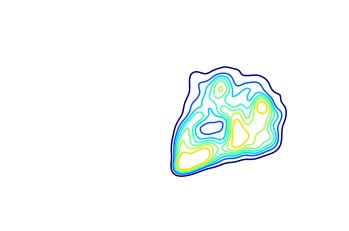

In [37]:
x = np.where(skel == 255)[1]
y = np.where(skel == 255)[0]*-1

sns.kdeplot(x, y, cmap=cm.jet, levels = 8, thresh=.2)
plt.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False,
                left=False, labelleft=False)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.savefig('8lvl_20thresh.png', transparent = True, dpi=800)
#plt.show()
#plt.show()
#plt.savefig('8lvl_20thresh.png', transparent = True, dpi=800)

C:\Users\liuy42\AppData\Roaming\Python\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


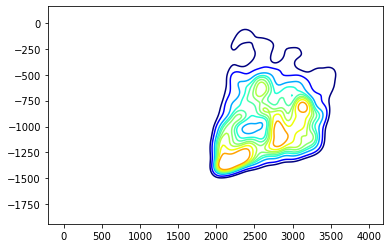

<Figure size 432x288 with 0 Axes>

In [19]:
sns.kdeplot(x, y, cmap=cm.jet, levels = 10, thresh=.1)
plt.show()
plt.savefig('10lvl_10thresh.png', transparent = True)